<a href="https://colab.research.google.com/github/DJEk200/Gb_bank/blob/main/Credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  **Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

  **Наименование файлов с данными**

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

  **Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

  **Метрика качества**

F1-score (sklearn.metrics.f1_score)

  **Требования к решению**

*Целевая метрика*

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*

Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

*Рекомендации для файла с кодом (ipynb)*

Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

  **Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.


  **Описание датасета**

**Home Ownership** - домовладение

**Annual Income** - годовой доход

**Years in current job** - количество лет на текущем месте работы

**Tax Liens** - налоговые обременения

**Number of Open Accounts** - количество открытых счетов

**Years of Credit History** - количество лет кредитной истории

**Maximum Open Credit** - наибольший открытый кредит

**Number of Credit Problems** - количество проблем с кредитом

**Months since last delinquent** - количество месяцев с последней просрочки платежа

**Bankruptcies** - банкротства

**Purpose** - цель кредита

**Term** - срок кредита

**Current Loan Amount** - текущая сумма кредита

**Current Credit Balance** - текущий кредитный баланс

**Monthly Debt** - ежемесячный долг

**Credit Score** - кредитный рейтинг: бальная оценка клиента

**Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import probplot

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [2]:
!pip install catboost

     |████████████████████████████████| 66.3MB 71kB/s 


In [3]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
TARGET_NAME = 'Credit Default'

In [5]:
ds_train = pd.read_csv(TRAIN_DATASET_PATH)
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
ds_test = pd.read_csv(TEST_DATASET_PATH)
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [7]:
ds_train.shape

(7500, 17)

In [8]:
ds_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


  **Credit Default**

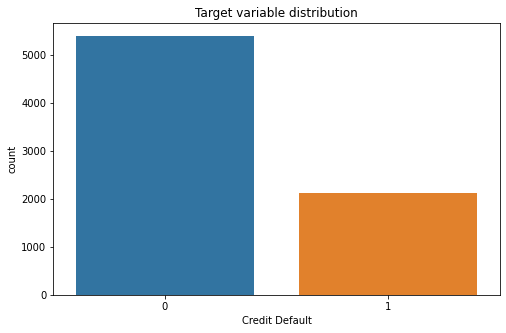

In [9]:
plt.figure(figsize=(8,5))

sns.countplot(x=TARGET_NAME,data=ds_train)
plt.title('Target variable distribution')

plt.show()

  **Home Ownership**

In [10]:

ds_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

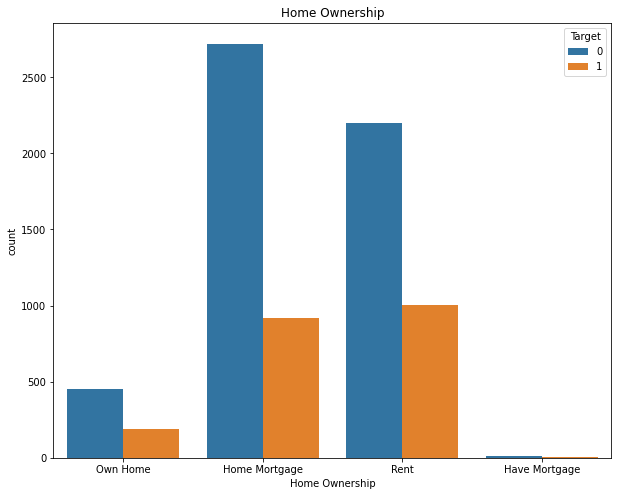

In [11]:
plt.figure(figsize=(10,8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=ds_train)
plt.title('Home Ownership')
plt.legend(title='Target', loc='upper right')

plt.show()

In [12]:
HomeOwnership_and_target_s = ds_train.loc[ds_train['Home Ownership'].isin(['Home Mortgage','Own Home']),\
                                    ['Tax Liens', 'Home Ownership',TARGET_NAME]]

In [13]:
table = HomeOwnership_and_target_s.pivot_table(values='Tax Liens', index='Home Ownership', columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
Home Mortgage,2721,916
Own Home,455,192


In [14]:
chi2, p, dof, expected=chi2_contingency(table,correction=False)
p

0.01625755488004322

In [15]:
dummies = pd.get_dummies(ds_train['Home Ownership']).rename(columns=lambda x: 'Home Ownership ' + str(x))
ds_train = pd.concat([ds_train, dummies], axis=1)
ds_train.drop(['Home Ownership'], inplace=True, axis=1)

In [16]:
dummies = pd.get_dummies(ds_test['Home Ownership']).rename(columns=lambda x: 'Home Ownership ' + str(x))
ds_test = pd.concat([ds_test, dummies], axis=1)
ds_test.drop(['Home Ownership'], inplace=True, axis=1)

  **Annual Income**

In [17]:
ds_train.loc[(ds_train['Annual Income'] > ds_train['Annual Income'].quantile(.90)), :].shape

(595, 20)

In [18]:
mean = ds_train['Annual Income'].mean()
ds_train.loc[(ds_train['Annual Income'].isnull()), ['Annual Income']] = mean

In [19]:
ds_test.loc[(ds_test['Annual Income'].isnull()), ['Annual Income']] = mean

In [20]:
shapiro(ds_train['Annual Income'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.7502869367599487, 0.0)

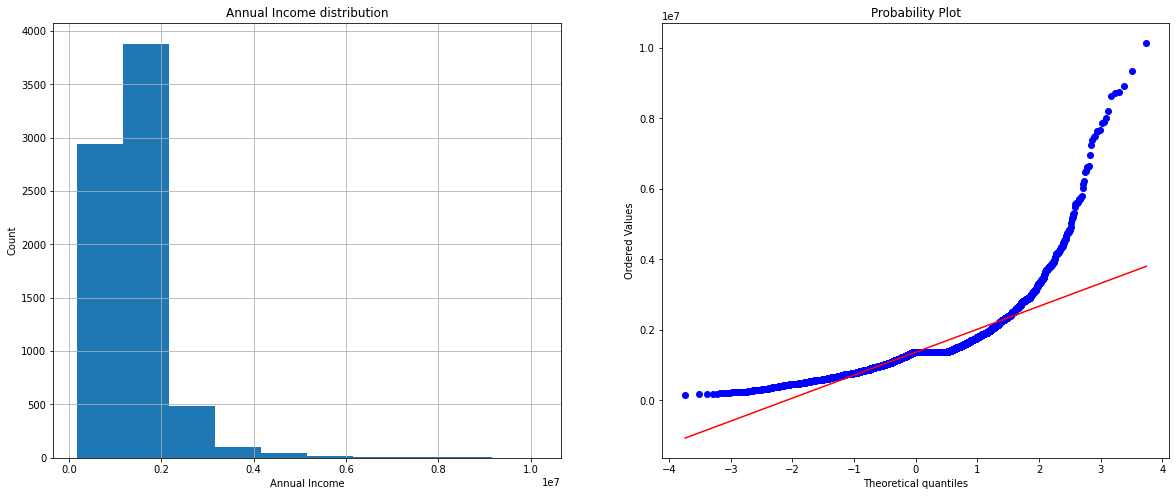

In [21]:
def hist_qq(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    ds_train[target_name].hist()
    plt.subplot(122)
    probplot(ds_train[target_name],dist='norm',plot=plt)

    plt.show()
    
hist_qq('Annual Income')


In [22]:
Annual_Income_with_target_s = ds_train[['Annual Income', TARGET_NAME]].sample(1000)
Annual_Income_target_0 = ds_train.loc[ds_train[TARGET_NAME] == 0, ['Annual Income']]
Annual_Income_target_1 = ds_train.loc[ds_train[TARGET_NAME] == 1, ['Annual Income']]

In [23]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=5077512.5, pvalue=1.3347021239648878e-13)

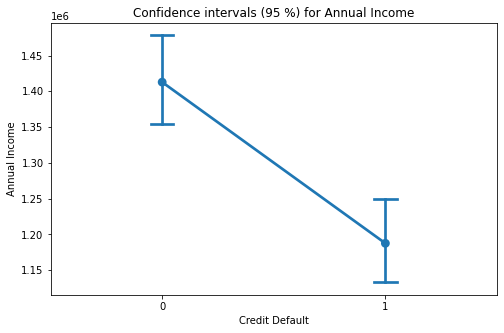

In [24]:
plt.figure(figsize=(8,5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

In [25]:
def boxcox(y):
    return(np.log(y))

In [26]:
ds_train['Annual Income'] = boxcox(ds_train.loc[:, 'Annual Income'])
ds_test['Annual Income'] = boxcox(ds_test.loc[:, 'Annual Income'])

  **Years in current job**
  
  количество лет на текущем месте работы

In [27]:
ds_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [28]:
def correct(value):
    if isinstance(value, int):
        return value
    if value == "< 1 year": 
        return 0
    elif value == "1 year":
        return 1
    elif value == "2 years":
        return 2
    elif value == "3 years":
        return 3
    elif value == "4 years":
        return 4
    elif value == "5 years":
        return 5
    elif value == "6 years":
        return 6
    elif value == "7 years":
        return 7
    elif value == "8 years":
        return 8
    elif value == "9 years":
        return 9
    elif value == "10+ years":
        return 10
    else:
        return 0

ds_train['Years in current job'] = ds_train['Years in current job'].apply(correct)

In [29]:
ds_test['Years in current job'] = ds_test['Years in current job'].apply(correct)

**Tax Liens**

In [30]:
ds_train['Tax Liens'].describe()

count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

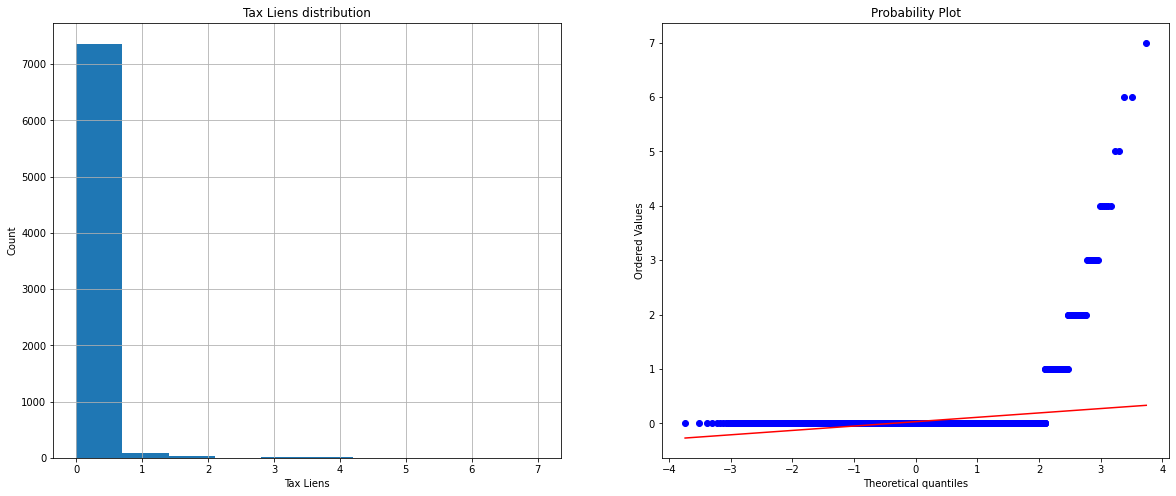

In [31]:
hist_qq('Tax Liens')

**Number of Open Accounts**

количество открытых счетов

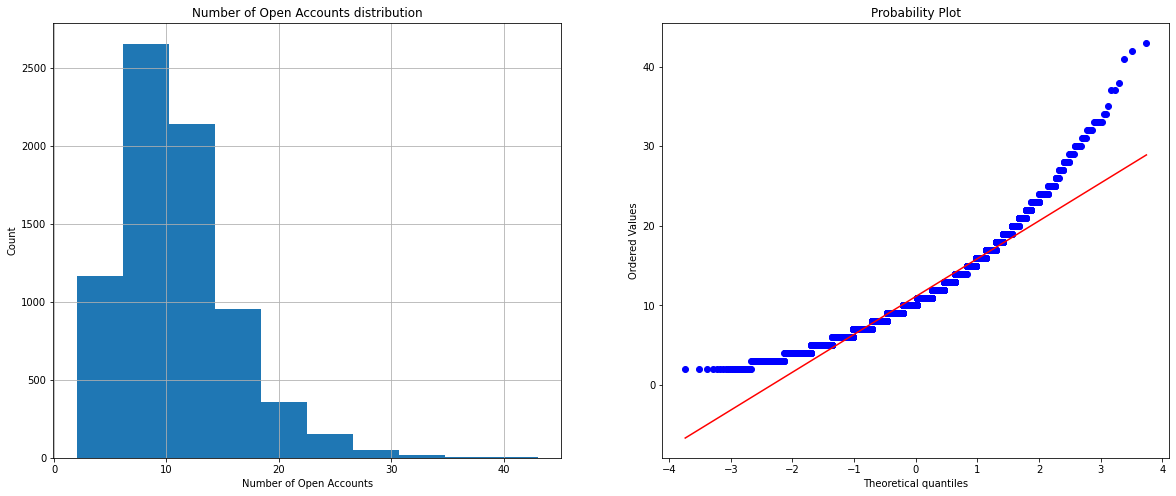

In [32]:
hist_qq('Number of Open Accounts')

In [33]:
NoOA_with_target_s = ds_train[['Number of Open Accounts', TARGET_NAME]].sample(1000)
NoOA_target_0 = ds_train.loc[ds_train[TARGET_NAME] == 0, ['Number of Open Accounts']]
NoOA_target_1 = ds_train.loc[ds_train[TARGET_NAME] == 1, ['Number of Open Accounts']]

In [34]:
mannwhitneyu(NoOA_target_0, NoOA_target_1)

MannwhitneyuResult(statistic=5466480.0, pvalue=0.003761646078803518)

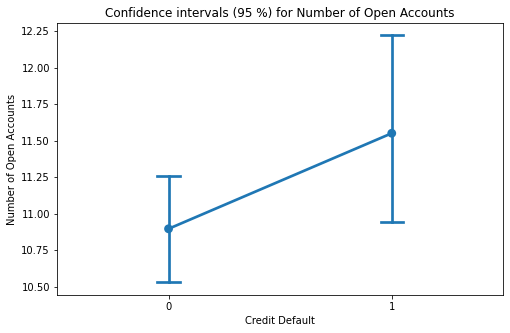

In [35]:
plt.figure(figsize=(8,5))

sns.pointplot(x=TARGET_NAME, y='Number of Open Accounts', data=NoOA_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Number of Open Accounts')

plt.show()

In [36]:
ds_train['Number of Open Accounts'] = boxcox(ds_train.loc[:, 'Number of Open Accounts'])
ds_test['Number of Open Accounts'] = boxcox(ds_test.loc[:, 'Number of Open Accounts'])

**Years of Credit History**

количество лет кредитной истории

In [37]:
ds_train['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

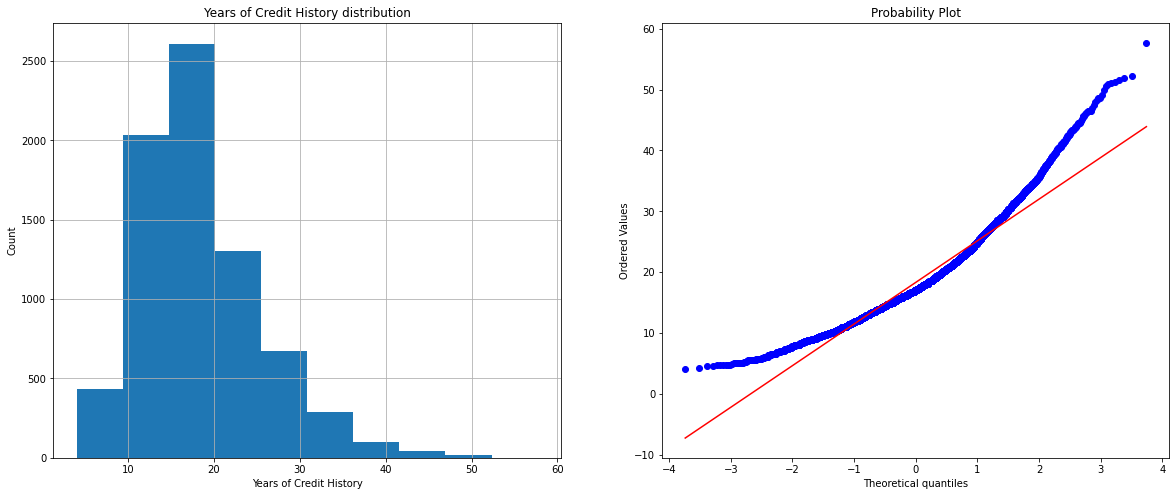

In [38]:
hist_qq('Years of Credit History')

In [39]:
YoCH_with_target_s = ds_train[['Years of Credit History', TARGET_NAME]].sample(1000)
YoCH_target_0 = ds_train.loc[ds_train[TARGET_NAME] == 0, ['Years of Credit History']]
YoCH_target_1 = ds_train.loc[ds_train[TARGET_NAME] == 1, ['Years of Credit History']]

In [40]:
mannwhitneyu(YoCH_target_0, YoCH_target_1)

MannwhitneyuResult(statistic=5461129.5, pvalue=0.003171215731103466)

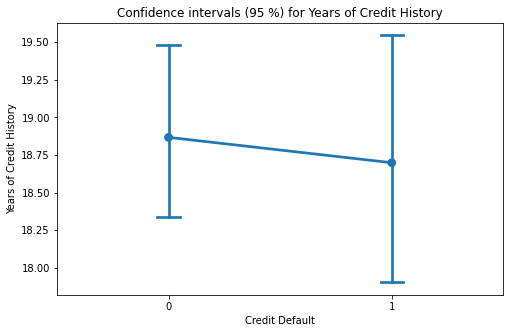

In [41]:
plt.figure(figsize=(8,5))

sns.pointplot(x=TARGET_NAME, y='Years of Credit History', data=YoCH_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Years of Credit History')

plt.show()

In [42]:
ds_train['Years of Credit History'] = boxcox(ds_train.loc[:, 'Years of Credit History'])
ds_test['Years of Credit History'] = boxcox(ds_test.loc[:, 'Years of Credit History'])

**Maximum Open Credit**

наибольший открытый кредит

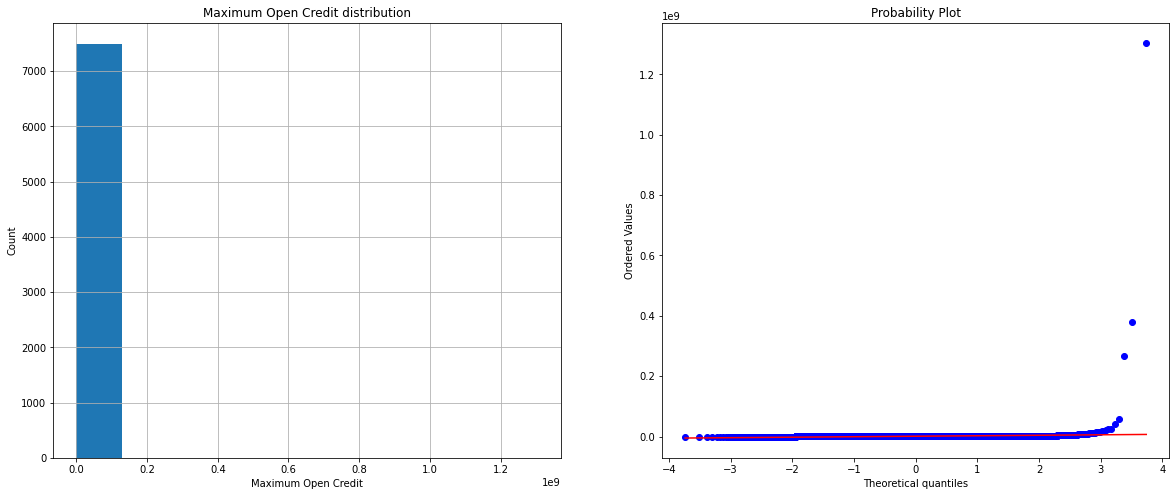

In [43]:
hist_qq('Maximum Open Credit')

In [44]:
ds_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

обработка выбросов

In [45]:
ds_train.loc[ ds_train['Maximum Open Credit'] > ds_train['Maximum Open Credit'].quantile(.99), :].shape

(75, 20)

In [46]:
mean = ds_train.loc[ :, 'Maximum Open Credit'].mean()
ds_train.loc[ ds_train['Maximum Open Credit'] > ds_train['Maximum Open Credit'].quantile(.99), ['Maximum Open Credit']]= mean

In [47]:
ds_test.loc[ ds_test['Maximum Open Credit'] > ds_train['Maximum Open Credit'].quantile(.99), ['Maximum Open Credit']]= mean

**Number of Credit Problems**

количество проблем с кредитом

In [48]:
ds_train['Number of Credit Problems'].describe()

count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

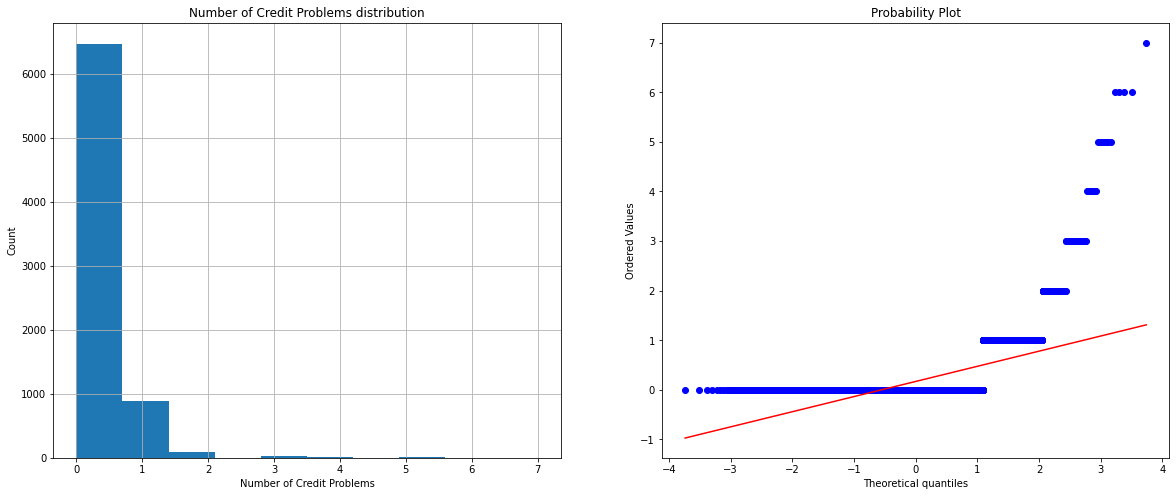

In [49]:
hist_qq('Number of Credit Problems')

обработка выбросов

In [50]:
ds_train.loc[ ds_train['Number of Credit Problems'] > ds_train['Number of Credit Problems'].quantile(.99), :].shape

(56, 20)

In [51]:
mean = ds_train.loc[ :, 'Number of Credit Problems'].mean()
ds_train.loc[ ds_train['Number of Credit Problems'] > ds_train['Number of Credit Problems'].quantile(.99), ['Number of Credit Problems']]= mean

In [52]:
ds_test.loc[ ds_test['Number of Credit Problems'] > ds_train['Number of Credit Problems'].quantile(.99), ['Number of Credit Problems']]= mean


**Months since last delinquent**

количество месяцев с последней просрочки платежа

In [53]:
ds_train.loc[ds_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
ds_test.loc[ds_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

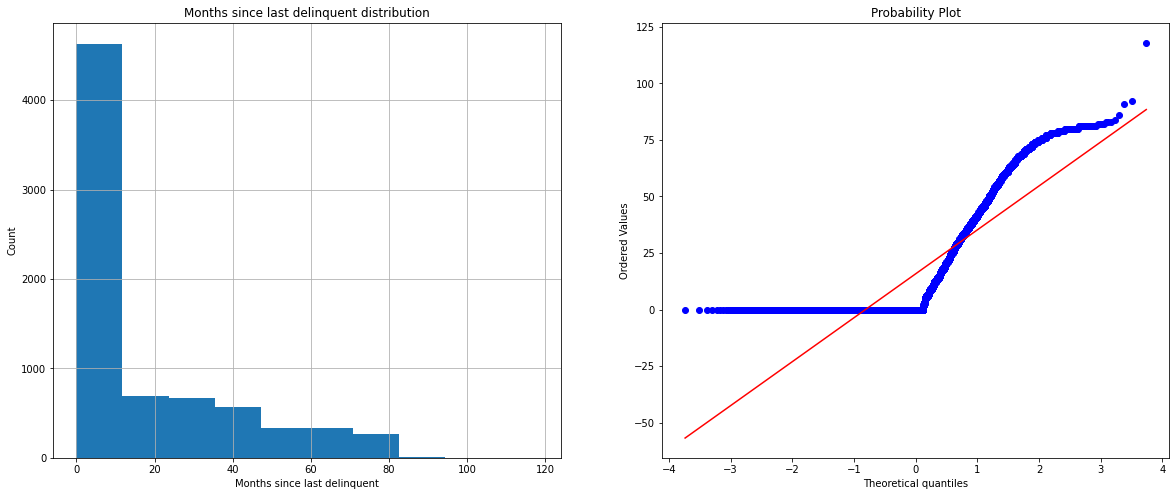

In [54]:
hist_qq('Months since last delinquent')

In [55]:
ds_train.loc[ ds_train['Months since last delinquent'] > ds_train['Months since last delinquent'].quantile(.99), :].shape

(59, 20)

In [56]:
mean = ds_train.loc[ :, 'Months since last delinquent'].mean()
ds_train.loc[ ds_train['Months since last delinquent'] > ds_train['Months since last delinquent'].quantile(.99), ['Months since last delinquent']]= mean

In [57]:
ds_test.loc[ ds_test['Months since last delinquent'] > ds_train['Months since last delinquent'].quantile(.99), ['Months since last delinquent']]= mean

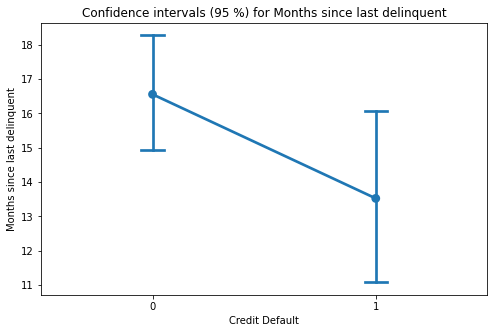

In [58]:
Msld_with_target_s = ds_train[['Months since last delinquent', TARGET_NAME]].sample(1000)
plt.figure(figsize=(8,5))

sns.pointplot(x=TARGET_NAME, y='Months since last delinquent', data=Msld_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Months since last delinquent')

plt.show()


**Bankruptcies**

банкротства

In [59]:
ds_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [60]:
ds_train.loc[ds_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
ds_test.loc[ds_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

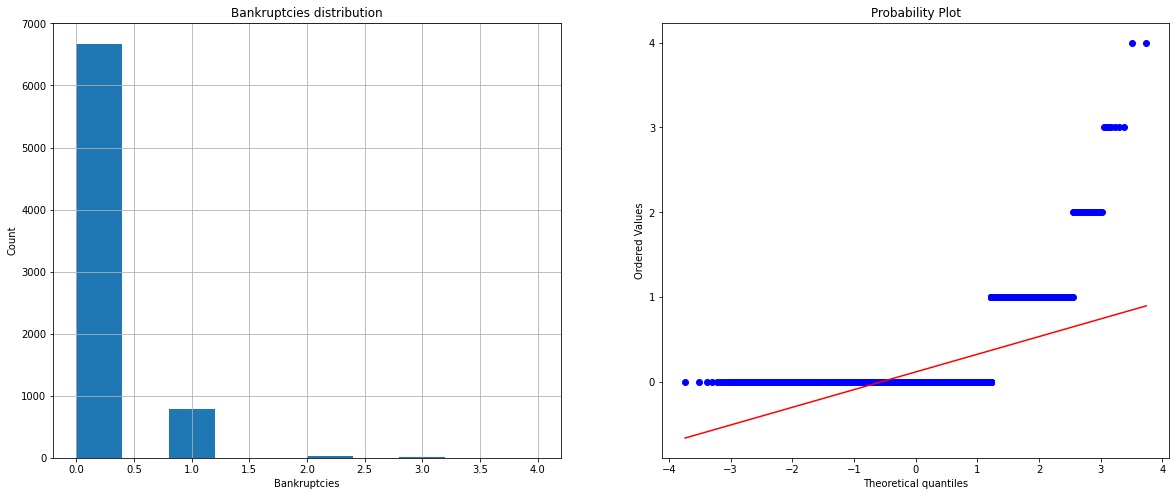

In [61]:
hist_qq('Bankruptcies')

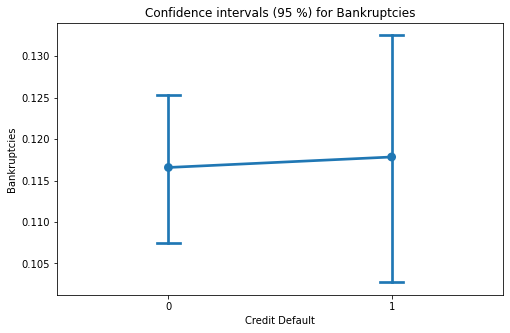

In [62]:
Bankruptcies_with_target_s = ds_train[['Bankruptcies', TARGET_NAME]]
plt.figure(figsize=(8,5))

sns.pointplot(x=TARGET_NAME, y='Bankruptcies', data=Bankruptcies_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Bankruptcies')

plt.show()

**Purpose**

цель кредита

In [63]:
ds_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [64]:
ds_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

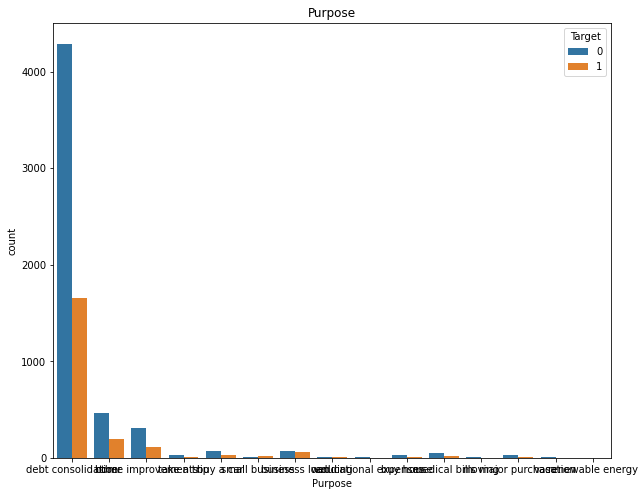

In [65]:
plt.figure(figsize=(10,8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=ds_train)
plt.title('Purpose')
plt.legend(title='Target', loc='upper right')

plt.show()

In [66]:
Purpose_and_target_s = ds_train.loc[ds_train['Purpose'].isin(['other','business loan']),\
                                    ['Tax Liens', 'Purpose',TARGET_NAME]]

In [67]:
table = Purpose_and_target_s.pivot_table(values='Tax Liens', index='Purpose', columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Purpose,,
business loan,74,55
other,468,197


In [68]:
chi2, p, dof, expected=chi2_contingency(table,correction=False)
p

0.0036646467408851567

In [69]:
ds_train.loc[ ds_train['Purpose'].isin(['home improvements','debt consolidation']),\
             ['Purpose']]= 'home improvements & debt consolidation'
ds_test.loc[ ds_test['Purpose'].isin(['home improvements','debt consolidation']),\
             ['Purpose']]= 'home improvements & debt consolidation'

In [70]:
dummies = pd.get_dummies(ds_train['Purpose']).rename(columns=lambda x: 'Purpose ' + str(x))
ds_train = pd.concat([ds_train, dummies], axis=1)
ds_train.drop(['Purpose'], inplace=True, axis=1)
ds_train.drop(['Purpose renewable energy'], inplace=True, axis=1)

dummies = pd.get_dummies(ds_test['Purpose']).rename(columns=lambda x: 'Purpose ' + str(x))
ds_test = pd.concat([ds_test, dummies], axis=1)
ds_test.drop(['Purpose'], inplace=True, axis=1)

**Term**

срок кредита

In [71]:
ds_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [72]:
ds_test['Term'].value_counts()

Short Term    1861
Long Term      639
Name: Term, dtype: int64

In [73]:
ds_train['Term'] = (ds_train['Term'] == 'Long Term').astype(int)
ds_test['Term'] = (ds_test['Term'] == 'Long Term').astype(int)
ds_train['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

**Current Loan Amount**

текущая сумма кредита

In [74]:
ds_train['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [75]:
ds_test['Current Loan Amount'].describe()

count    2.500000e+03
mean     1.215572e+07
std      3.226097e+07
min      1.542200e+04
25%      1.871265e+05
50%      3.223660e+05
75%      5.225825e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [76]:
ds_train.loc[ ds_train['Current Loan Amount'] > ds_train['Current Loan Amount'].quantile(.99), :].shape

(0, 32)

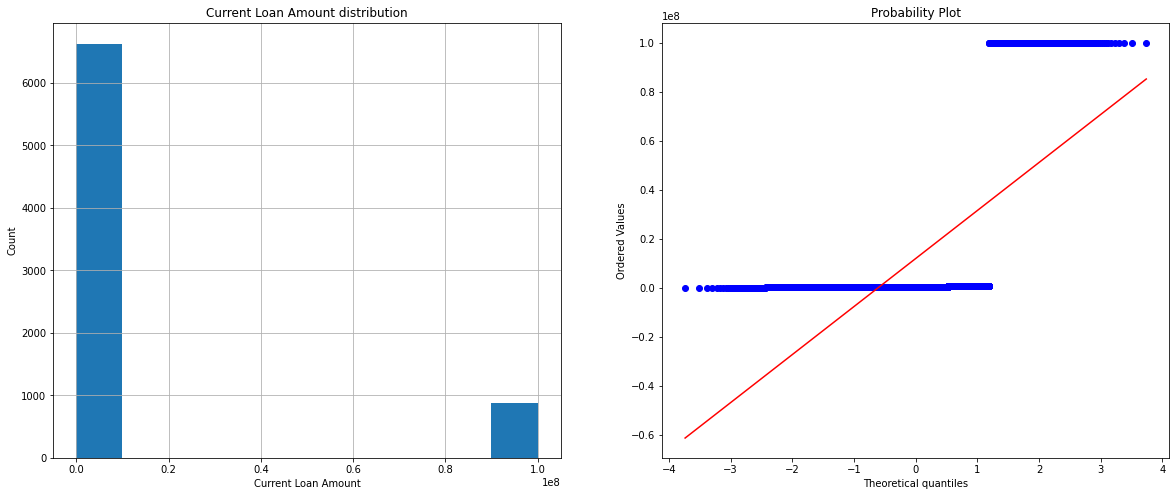

In [77]:
hist_qq('Current Loan Amount')


**Current Credit Balance**

текущий кредитный баланс

In [78]:
ds_train['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

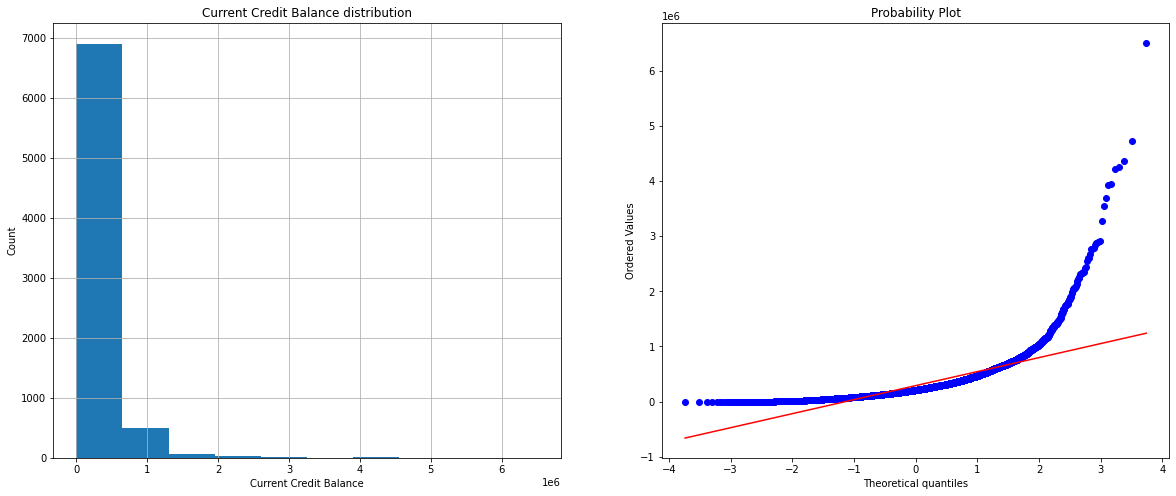

In [79]:
hist_qq('Current Credit Balance')

обработка выбросов

In [80]:
ds_train.loc[ ds_train['Current Credit Balance'] > ds_train['Current Credit Balance'].quantile(.99), :].shape

(75, 32)

In [81]:
mean = ds_train.loc[ :, 'Current Credit Balance'].mean()
ds_train.loc[ ds_train['Current Credit Balance'] > ds_train['Current Credit Balance'].quantile(.99), ['Current Credit Balance']]= mean

In [82]:
ds_test.loc[ ds_test['Current Credit Balance'] > ds_train['Current Credit Balance'].quantile(.99), ['Current Credit Balance']]= mean

**Monthly Debt**

ежемесячный долг

In [83]:
ds_train['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

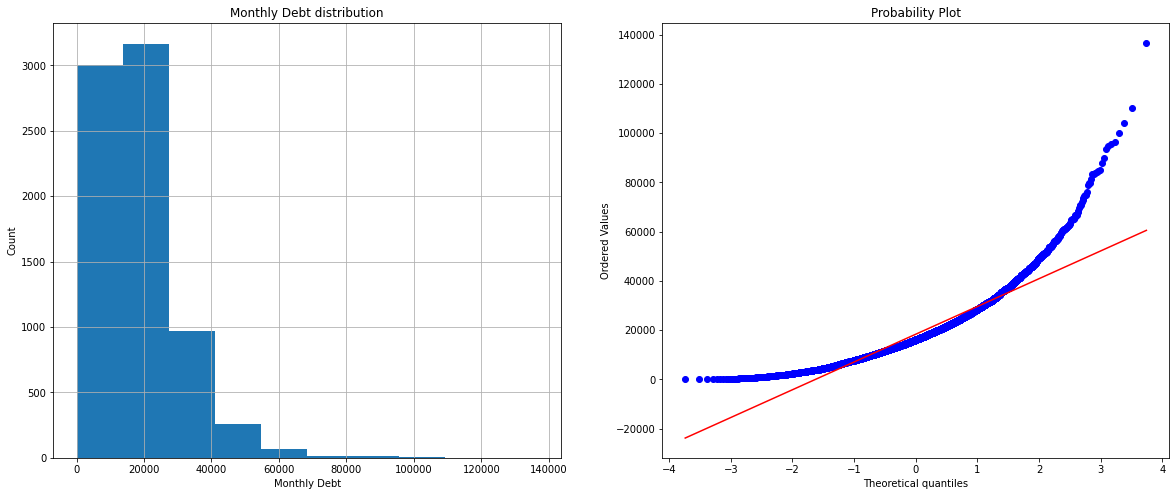

In [84]:
hist_qq('Monthly Debt')

In [85]:
mean = ds_train.loc[ :, 'Monthly Debt'].mean()
ds_train.loc[ ds_train['Monthly Debt'] > ds_train['Monthly Debt'].quantile(.99), ['Monthly Debt']]= mean
mean = ds_test.loc[ :, 'Monthly Debt'].mean()
ds_test.loc[ ds_test['Monthly Debt'] > ds_test['Monthly Debt'].quantile(.99), ['Monthly Debt']]= mean

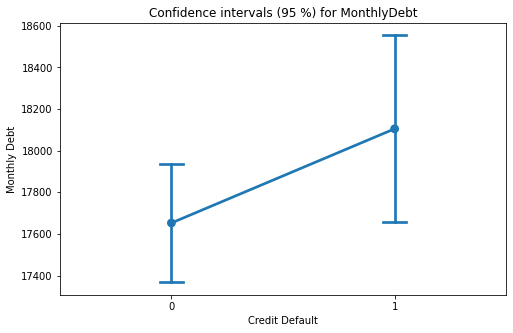

In [86]:
MonthlyDebt_with_target_s = ds_train[['Monthly Debt', TARGET_NAME]]
plt.figure(figsize=(8,5))

sns.pointplot(x=TARGET_NAME, y='Monthly Debt', data=MonthlyDebt_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for MonthlyDebt')

plt.show()

**Credit Score**

кредитный рейтинг: бальная оценка клиента

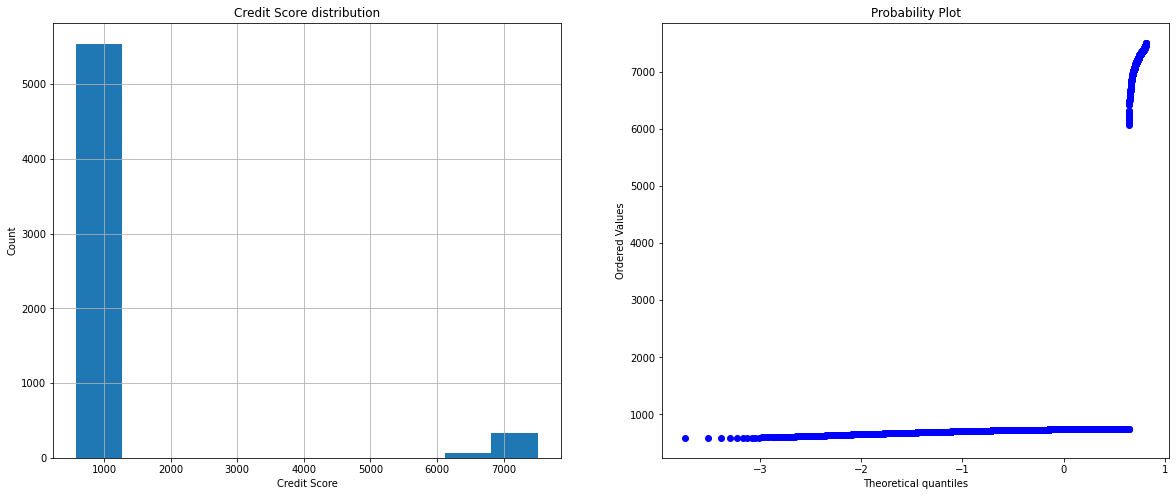

In [87]:
hist_qq('Credit Score')

In [88]:
ds_train.loc[ ds_train['Credit Score'] > ds_train['Credit Score'].quantile(.99), ['Credit Score']].shape

(57, 1)

In [89]:
train_data_CS_mean = ds_train.loc[ds_train['Credit Score'].notnull(), 'Credit Score'].median(axis=0)
ds_train.loc[ds_train['Credit Score'].isnull(), 'Credit Score'] = train_data_CS_mean
ds_test.loc[ds_test['Credit Score'].isnull(), 'Credit Score'] = train_data_CS_mean

In [90]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 32 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Annual Income                                   7500 non-null   float64
 1   Years in current job                            7500 non-null   int64  
 2   Tax Liens                                       7500 non-null   float64
 3   Number of Open Accounts                         7500 non-null   float64
 4   Years of Credit History                         7500 non-null   float64
 5   Maximum Open Credit                             7500 non-null   float64
 6   Number of Credit Problems                       7500 non-null   float64
 7   Months since last delinquent                    7500 non-null   float64
 8   Bankruptcies                                    7500 non-null   float64
 9   Term                                     

In [91]:
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 31 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Annual Income                                   2500 non-null   float64
 1   Years in current job                            2500 non-null   int64  
 2   Tax Liens                                       2500 non-null   float64
 3   Number of Open Accounts                         2500 non-null   float64
 4   Years of Credit History                         2500 non-null   float64
 5   Maximum Open Credit                             2500 non-null   float64
 6   Number of Credit Problems                       2500 non-null   float64
 7   Months since last delinquent                    2500 non-null   float64
 8   Bankruptcies                                    2500 non-null   float64
 9   Term                                     

In [92]:
BASE_FEATURE_NAMES = ds_train.columns.drop(TARGET_NAME).tolist()

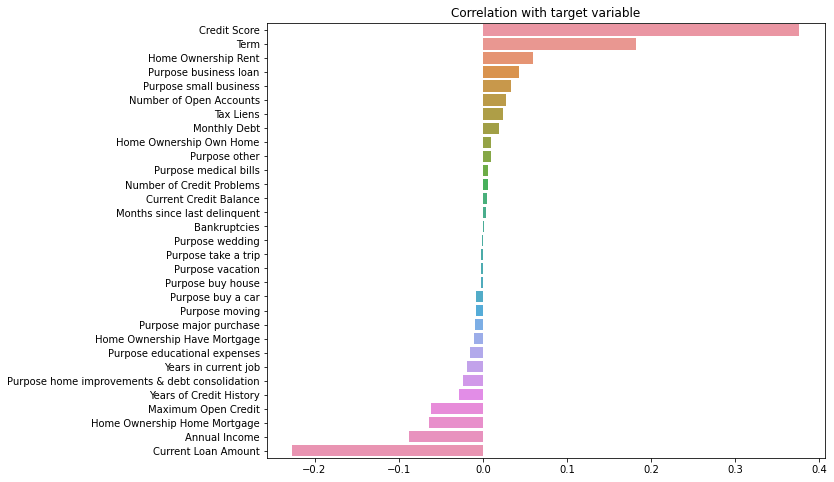

In [93]:
corr_with_target = ds_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

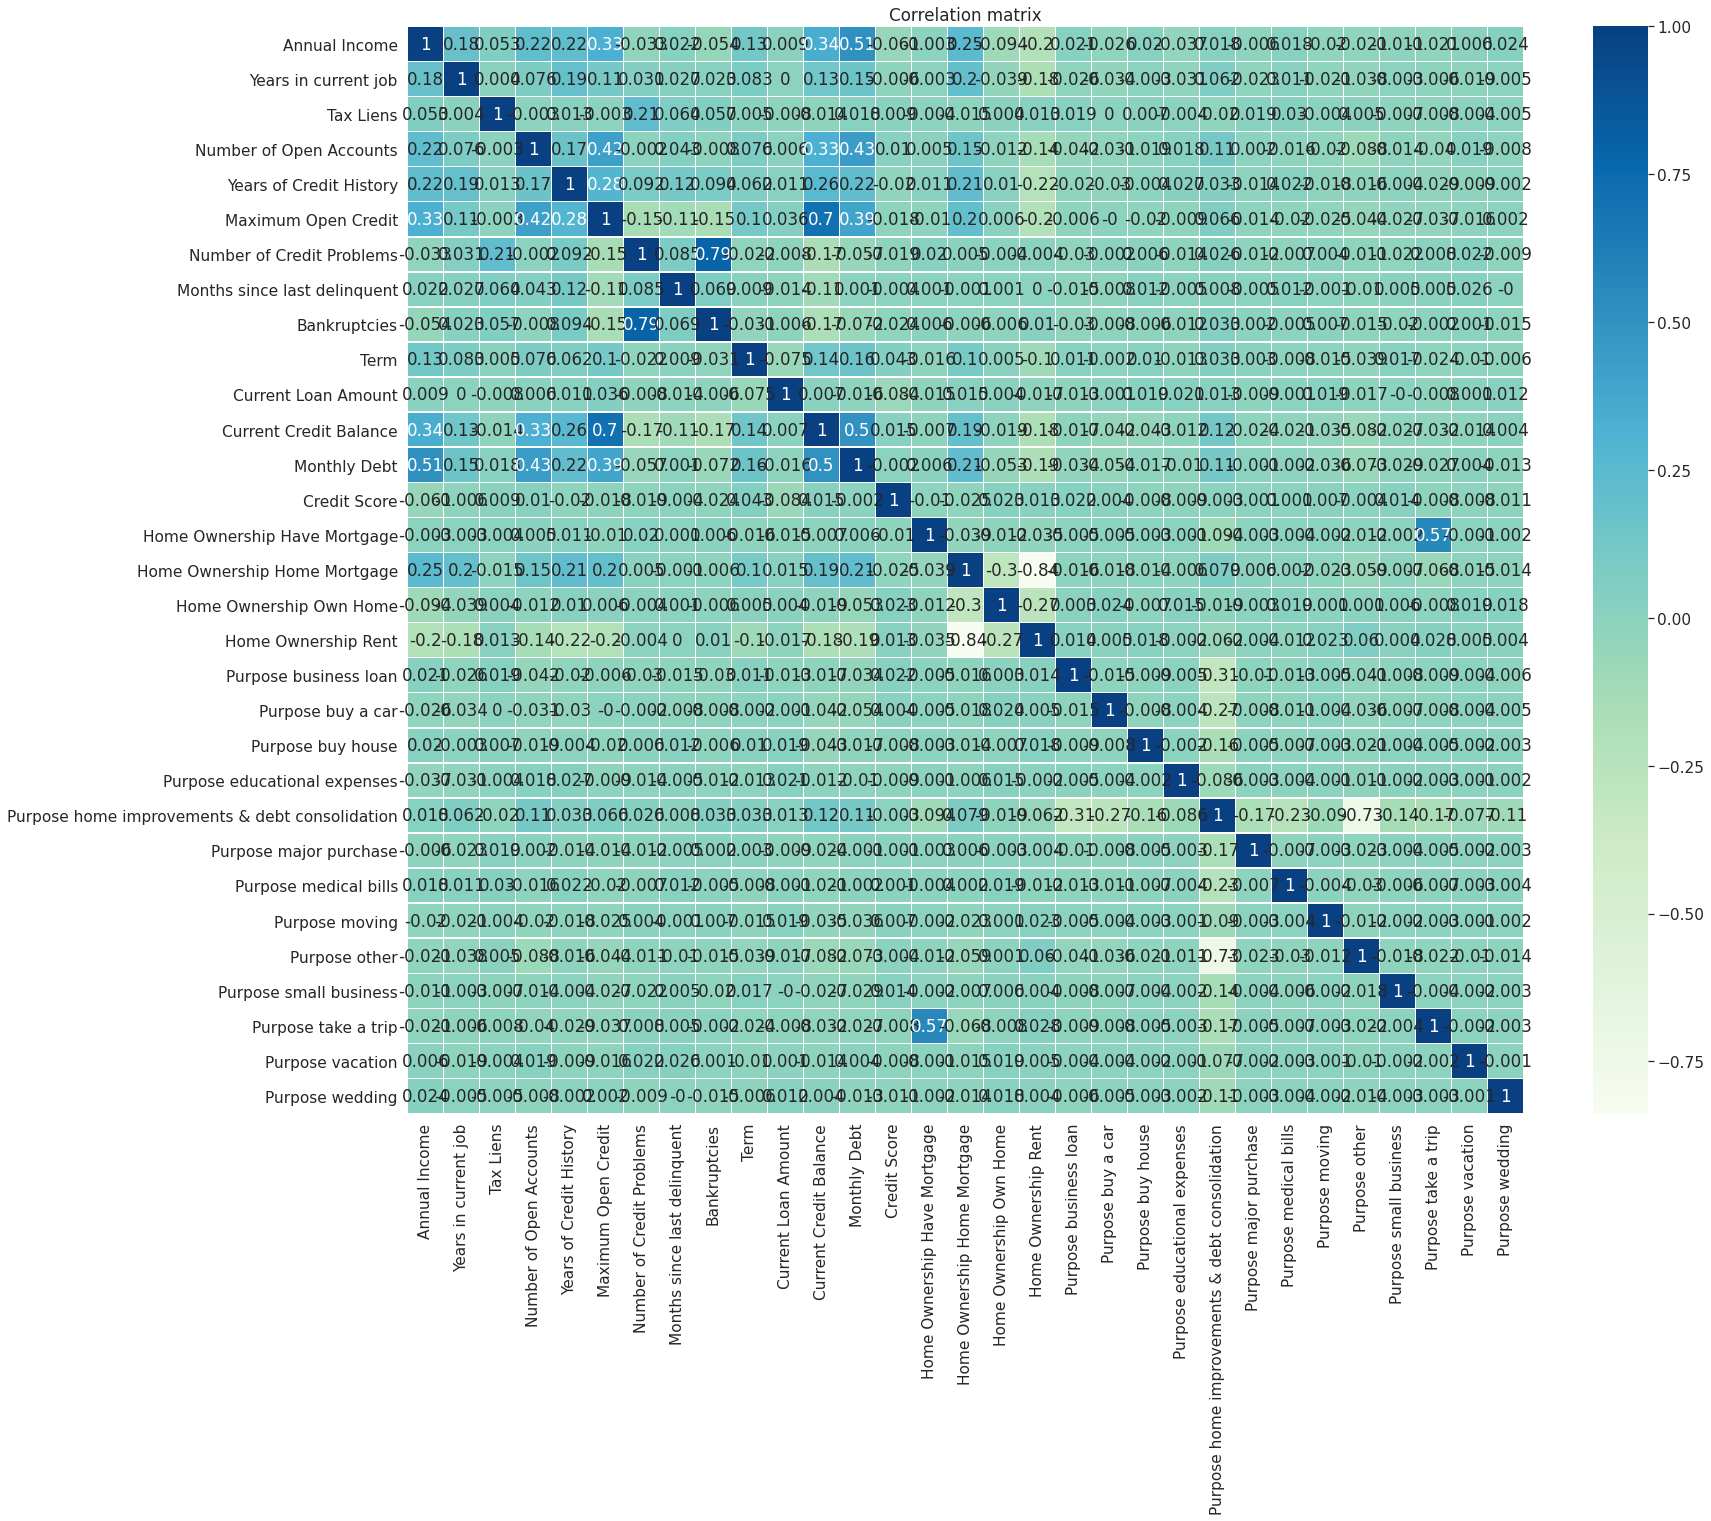

In [94]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(ds_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Выделение целевой переменной и групп признаков**

In [95]:
ds_train_result = ds_train['Credit Default']

In [96]:
ds_train.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Home Ownership Have Mortgage',
       'Home Ownership Home Mortgage', 'Home Ownership Own Home',
       'Home Ownership Rent', 'Purpose business loan', 'Purpose buy a car',
       'Purpose buy house', 'Purpose educational expenses',
       'Purpose home improvements & debt consolidation',
       'Purpose major purchase', 'Purpose medical bills', 'Purpose moving',
       'Purpose other', 'Purpose small business', 'Purpose take a trip',
       'Purpose vacation', 'Purpose wedding'],
      dtype='object')

In [97]:
FEATURE_NAMES_SELECTED = ['Annual Income', 
                          'Years in current job', 
                          'Tax Liens',
                          'Number of Open Accounts', 
                          'Years of Credit History',
                          'Maximum Open Credit', 
                          'Number of Credit Problems',
                          #'Months since last delinquent', 
                          #'Bankruptcies',
                          'Term',
                          'Current Loan Amount',
                          'Current Credit Balance',
                          'Monthly Debt',                          
                          'Credit Score', 
                          #'Credit Default',
                          
                          'Home Ownership Have Mortgage',
                          'Home Ownership Home Mortgage',
                          'Home Ownership Own Home',
                          'Home Ownership Rent', 
                          
                          'Purpose home improvements & debt consolidation',
                          'Purpose business loan', 
                          'Purpose buy a car',
                          #'Purpose buy house',
                          'Purpose educational expenses',
                          'Purpose major purchase',
                          'Purpose medical bills',
                          'Purpose moving',
                          #'Purpose other', 
                          'Purpose small business', 
                          #'Purpose take a trip',
                          #'Purpose vacation',
                          #'Purpose wedding'
                         ]

In [98]:
ds_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,7500.0,1.401523e+01,4.685720e-01,12.011255,13.744157,14.127684,14.220958,1.613292e+01
Years in current job,7500.0,5.589467e+00,3.752707e+00,0.000000,2.000000,6.000000,10.000000,1.000000e+01
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.000000,0.000000,0.000000,0.000000,7.000000e+00
Number of Open Accounts,7500.0,2.313792e+00,4.484374e-01,0.693147,2.079442,2.302585,2.639057,3.761200e+00
Years of Credit History,7500.0,2.836961e+00,3.796236e-01,1.386294,2.602690,2.833213,3.081910,4.055257e+00
Maximum Open Credit,7500.0,6.084231e+05,4.844779e+05,0.000000,279229.500000,478159.000000,793501.500000,3.567982e+06
Number of Credit Problems,7500.0,1.436693e-01,3.831377e-01,0.000000,0.000000,0.000000,0.000000,2.000000e+00
Months since last delinquent,7500.0,1.529601e+01,2.186871e+01,0.000000,0.000000,0.000000,28.000000,7.900000e+01
Bankruptcies,7500.0,1.169333e-01,3.469044e-01,0.000000,0.000000,0.000000,0.000000,4.000000e+00
Term,7500.0,2.592000e-01,4.382248e-01,0.000000,0.000000,0.000000,1.000000,1.000000e+00


**Нормализация данных**

In [99]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 
                          'Years in current job', 
                          'Tax Liens',
                          'Number of Open Accounts',
                          'Years of Credit History',
                          'Maximum Open Credit', 
                          'Number of Credit Problems',
                          'Months since last delinquent', 
                          'Bankruptcies',
                          'Term',
                          'Current Loan Amount',
                          'Current Credit Balance',
                          'Monthly Debt',                          
                          'Credit Score'
                        ]


scaler = StandardScaler()

ds_norm = ds_train.copy()
ds_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(ds_norm[NUMERIC_FEATURE_NAMES])

ds_train = ds_norm.copy()

**Разбиение на train и test**

In [100]:
X = ds_train[FEATURE_NAMES_SELECTED]
y = ds_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

**Балансировка данных**

In [101]:
def balance_ds_by_target(ds, target_name):

    target_counts = ds[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = ds[ds[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        ds = ds.append(sample, ignore_index=True)

    return ds.sample(frac=1)

In [102]:
X_train.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership Have Mortgage',
       'Home Ownership Home Mortgage', 'Home Ownership Own Home',
       'Home Ownership Rent', 'Purpose home improvements & debt consolidation',
       'Purpose business loan', 'Purpose buy a car',
       'Purpose educational expenses', 'Purpose major purchase',
       'Purpose medical bills', 'Purpose moving', 'Purpose small business'],
      dtype='object')

In [103]:
ds_for_balancing = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
ds_balanced = balance_ds_by_target(ds_for_balancing, TARGET_NAME)
    
ds_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [104]:
ds_for_balancing[TARGET_NAME].value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

**Построение и оценка базовых моделей**

Логистическая регрессия

In [105]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [106]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3771
           1       0.82      0.27      0.40      1479

    accuracy                           0.78      5250
   macro avg       0.80      0.62      0.63      5250
weighted avg       0.79      0.78      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1616
           1       0.79      0.24      0.37       634

    accuracy                           0.77      2250
   macro avg       0.78      0.61      0.62      2250
weighted avg       0.77      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1576   40
1                479  155


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [107]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3771
           1       0.76      0.49      0.59      1479

    accuracy                           0.81      5250
   macro avg       0.79      0.71      0.73      5250
weighted avg       0.80      0.81      0.80      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1616
           1       0.54      0.35      0.42       634

    accuracy                           0.73      2250
   macro avg       0.66      0.62      0.62      2250
weighted avg       0.71      0.73      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1432  184
1                415  219


In [108]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      3771
           1       0.94      0.28      0.44      1479

    accuracy                           0.79      5250
   macro avg       0.86      0.64      0.66      5250
weighted avg       0.83      0.79      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1616
           1       0.86      0.25      0.39       634

    accuracy                           0.78      2250
   macro avg       0.82      0.62      0.63      2250
weighted avg       0.80      0.78      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1591   25
1                476  158


In [109]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3771
           1       0.99      0.68      0.80      1479

    accuracy                           0.91      5250
   macro avg       0.94      0.84      0.87      5250
weighted avg       0.92      0.91      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1616
           1       0.65      0.35      0.45       634

    accuracy                           0.76      2250
   macro avg       0.72      0.64      0.65      2250
weighted avg       0.75      0.76      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1497  119
1                413  221


In [110]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3771
           1       0.97      0.57      0.72      1479

    accuracy                           0.87      5250
   macro avg       0.91      0.78      0.82      5250
weighted avg       0.89      0.87      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1616
           1       0.70      0.29      0.42       634

    accuracy                           0.77      2250
   macro avg       0.74      0.62      0.63      2250
weighted avg       0.75      0.77      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1537   79
1                447  187


выбор лучшей модели

In [111]:
model = lgbm.LGBMClassifier(random_state=21)

In [112]:
params = {'num_leaves': [20, 25, 30, 35],
          'max_depth': [-1, 0,3, 5, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1],
          'n_estimators':[50, 100, 200, 500],
          #'reg_alpha':[0.001, 0.01, 0.1, 1, 5],
          'reg_lambda':[0.001, 0.01, 0.1, 1, 5]
          }

In [113]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [114]:
%%time

rs = RandomizedSearchCV(model, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 937 ms, sys: 58 ms, total: 995 ms
Wall time: 9.01 s


In [115]:
best_param = rs.best_params_
best_param

{'learning_rate': 0.05,
 'max_depth': 0,
 'n_estimators': 500,
 'num_leaves': 20,
 'reg_lambda': 1}

In [116]:
%%time

final_model = lgbm.LGBMClassifier(num_leaves=best_param['num_leaves'], n_estimators=best_param['n_estimators'],\
                                  max_depth=best_param['max_depth'], learning_rate=best_param['learning_rate'],\
                                  #reg_alpha=best_param['reg_alpha'], 
                                  reg_lambda=best_param['reg_lambda'],
                                  random_state=42)
#final_model.set_params(best_param)
final_model.fit(X_train, y_train)


y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3771
           1       0.99      0.76      0.86      1479

    accuracy                           0.93      5250
   macro avg       0.95      0.88      0.91      5250
weighted avg       0.93      0.93      0.93      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1616
           1       0.66      0.34      0.45       634

    accuracy                           0.77      2250
   macro avg       0.72      0.64      0.65      2250
weighted avg       0.75      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1504  112
1                416  218
CPU times: user 1.03 s, sys: 18.7 ms, total: 1.05 s
Wall time: 1.05 s


Подбор оптимального размера выборки, кривая обучения

In [117]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, 
        cv=cv, 
        scoring='f1',
        train_sizes=train_sizes, 
        n_jobs=n_jobs,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

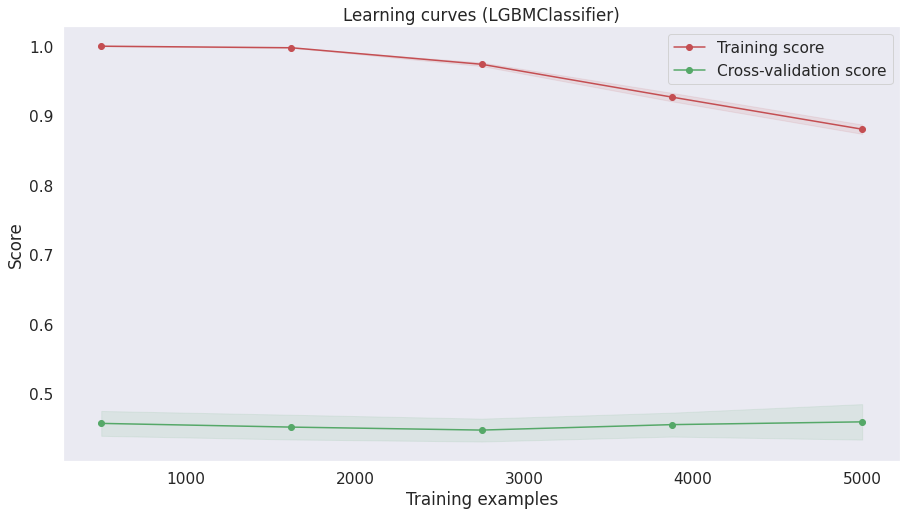

In [118]:
show_learning_curve_plot(final_model, X, y)

Выбор порога вероятности для определения класса

In [119]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

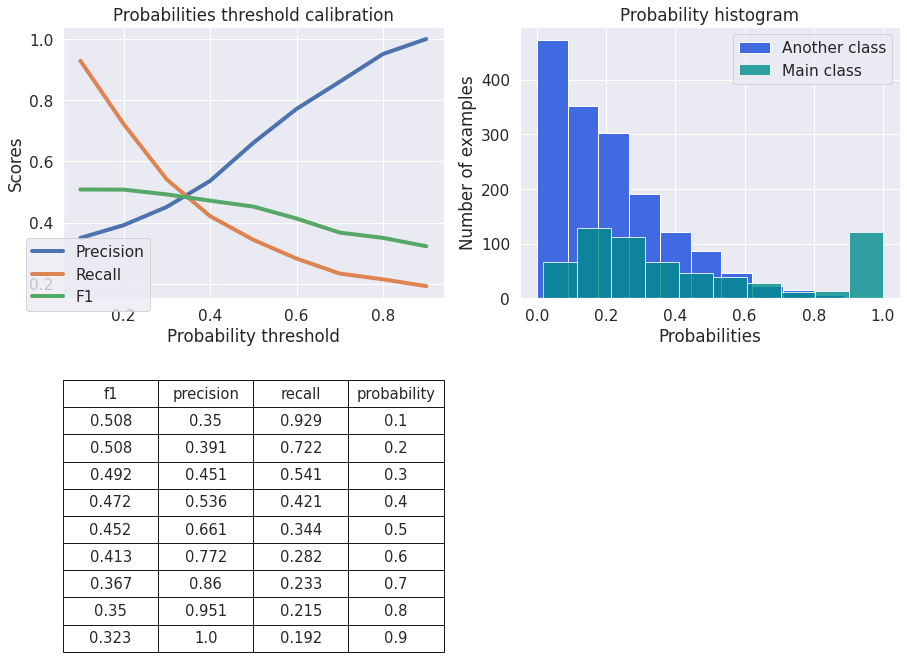

In [120]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [121]:
final_model.fit(X, y)


y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3771
           1       0.98      0.66      0.79      1479

    accuracy                           0.90      5250
   macro avg       0.93      0.83      0.86      5250
weighted avg       0.91      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1616
           1       0.97      0.66      0.79       634

    accuracy                           0.90      2250
   macro avg       0.93      0.83      0.86      2250
weighted avg       0.91      0.90      0.89      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1604   12
1                216  418


Подготовка результата

In [122]:
ds_norm_test = ds_test.copy()
ds_norm_test[NUMERIC_FEATURE_NAMES] = scaler.transform(ds_norm_test[NUMERIC_FEATURE_NAMES])

ds_test = ds_norm_test.copy()

In [123]:
X_result = ds_test[FEATURE_NAMES_SELECTED]

result = final_model.predict(X_result)

In [124]:
result = pd.DataFrame(result, columns=[TARGET_NAME])
result.head(5)

,Credit Default
0,0
1,0
2,1
3,0
4,0


In [125]:
result.to_csv(r'SSKulik_predictions.csv', index=False)